In [21]:
%load_ext watermark 
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import pytensor as pt
import altair as alt
alt.renderers.enable('mimetype')

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


RendererRegistry.enable('mimetype')

In [22]:
%watermark --iversions

pytensor  : 2.10.1
pandas    : 1.5.3
pymc      : 5.1.2
altair    : 4.2.2
matplotlib: 3.7.0
arviz     : 0.14.0
numpy     : 1.24.2



# Bayesian imputation

This notebook is based off Statistical Rethinking 14.5.1 - phylogenetic distances.

In [23]:
primates = pd.read_csv("../../../datasets/Primates301.csv")
primates.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


In [24]:
complete_primates = primates[['name', 'brain', 'body', 'group_size']].dropna()
complete_names = complete_primates.name.values
missing_primates = primates.loc[primates[['brain']].dropna().index, ['name', 'brain', 'body', 'group_size']]
missing_names = missing_primates.name.values

In [25]:
complete_phylogeny = pd.read_csv("../../../datasets/Primates_phylogeny.csv")
missing_phylogeny = pd.read_csv("../../../datasets/phylogeny_all.csv")

## Model that does not use missing data

In [62]:
def standardize(a):
    return (a - a.mean()) / a.std()

def mask_data(a):
    return np.ma.masked_where(a.isna(), a.values)

def register_data(RVs, data, df):
    #data    
    data['B'] = pm.MutableData("group size", standardize(np.log(mask_data(df['brain']))), dims="species", coords={'species': df['name'].values})
    #data['M'] = pm.MutableData("body mass", standardize(np.log(mask_data(df['body']))), dims="species")
    #data['B'] = pm.MutableData("brain size", standardize(np.log(mask_data(df['brain']))), dims="species")
    data['M'] = standardize(np.log(mask_data(df['body'])))
    data['G'] = standardize(np.log(mask_data(df['group_size'])))

def gp_priors(RVs, data): 

    #priors for GP mean
    RVs['α'] = pm.Normal("α", 0, 1)
    RVs['β'] = pm.Normal("β", 0, 0.5, dims='params')
    # priors for GP covariance
    RVs['η_squared'] = pm.Exponential("η_squared", 1)
    RVs['ρ'] = pm.Normal("ρ", 3, sigma=0.25)

    #prior for GP noise
    RVs['sigma'] = pm.Exponential("sigma", 1.0)


In [49]:
def add_distances(RVs, data, df):
    raw_dist = df.values.copy()    
    data['distances'] = pm.MutableData("distances", raw_dist, coords=['species', 'species'])

In [50]:
class ExponentialHack(pm.gp.cov.Stationary):
    def full(self, X, Xs=None):        
        return pt.tensor.exp(-0.5 * (X) / pm.math.sqrt(self.ls))
        
class LinearMean(pm.gp.mean.Linear):
    def __init__(self, coeffs, intercept=0, X=None):
        super().__init__(coeffs, intercept)
        self.X = X        

    def __call__(self, X):
        #return self.b + self.A * self.X
        return pt.tensor.squeeze(pt.tensor.dot(self.X, self.A) + self.b)

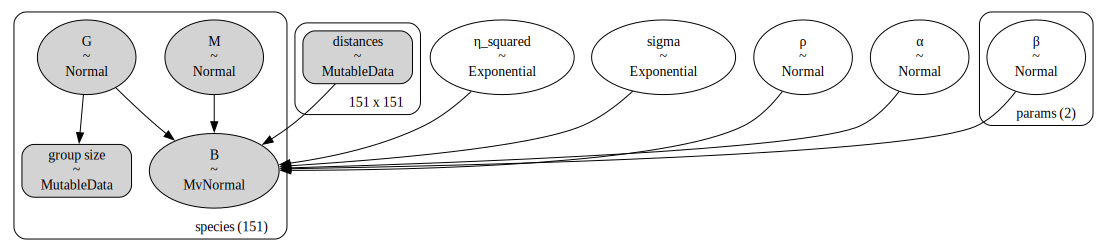

In [51]:
coords = {        
        'params': ['Group size', 'Body Mass']
    }

with pm.Model(coords= coords) as complete_cases_model:
    data = {}
    RVs = {}
    register_data(RVs, data, complete_primates)
    add_distances(RVs, data, complete_phylogeny)
    gp_priors(RVs, data)

    ls = 1 / (2 * RVs['ρ'])    
    cov_func = RVs['η_squared'] * ExponentialHack(input_dim=data['distances'].shape.eval()[0], ls=ls) 

    G = pm.Normal("G", mu=0, sigma=1, observed = data['G'], dims='species')
    M = pm.Normal("M", mu=0, sigma=1, observed = data['M'], dims='species')

    mu = LinearMean(intercept=RVs['α'], coeffs=RVs['β'], X=pt.tensor.stack([G, M], axis=1))
    gp = pm.gp.Marginal(mean_func = mu, cov_func=cov_func)
    gp.marginal_likelihood("B", X=data['distances'], y=data['B'], sigma=RVs['sigma'], dims="species")

pm.model_to_graphviz(complete_cases_model)

In [52]:
with complete_cases_model:
    complete_cases_trace = sampling_jax.sample_blackjax_nuts()    

Compiling...
Compilation time =  0:00:03.112737
Sampling...
Sampling time =  0:00:05.170460
Transforming variables...
Transformation time =  0:00:56.057701


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.111,0.173,-0.428,0.209,0.002,0.002,5788.0,3116.0,1.0
β[Group size],0.027,0.020,-0.013,0.062,0.000,0.000,5565.0,2976.0,1.0
β[Body Mass],0.780,0.030,0.722,0.834,0.000,0.000,4456.0,3305.0,1.0
ρ,2.969,0.240,2.549,3.454,0.003,0.002,5196.0,2917.0,1.0
η_squared,0.077,0.013,0.053,0.101,0.000,0.000,4172.0,3219.0,1.0
sigma,0.054,0.009,0.036,0.070,0.000,0.000,4389.0,2793.0,1.0


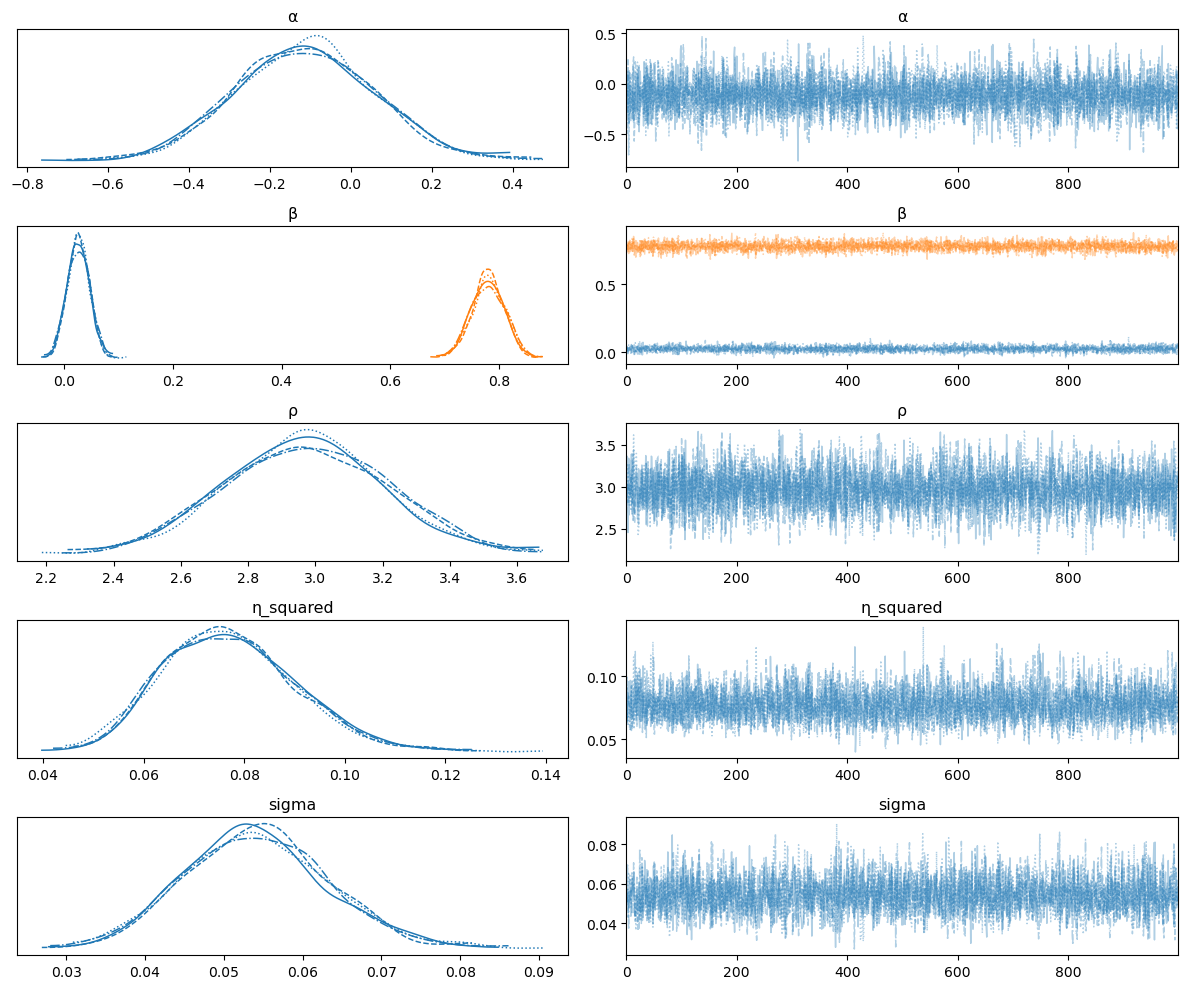

In [60]:
def show_results(trace, var_names=None):
    display(az.summary(trace, var_names=var_names))
    az.plot_trace(trace, var_names=var_names)
    plt.tight_layout()
    plt.show()

show_results(complete_cases_trace)

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/model.py:1402: ImputationWarning: Data in G contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/model.py:1402: ImputationWarning: Data in M contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


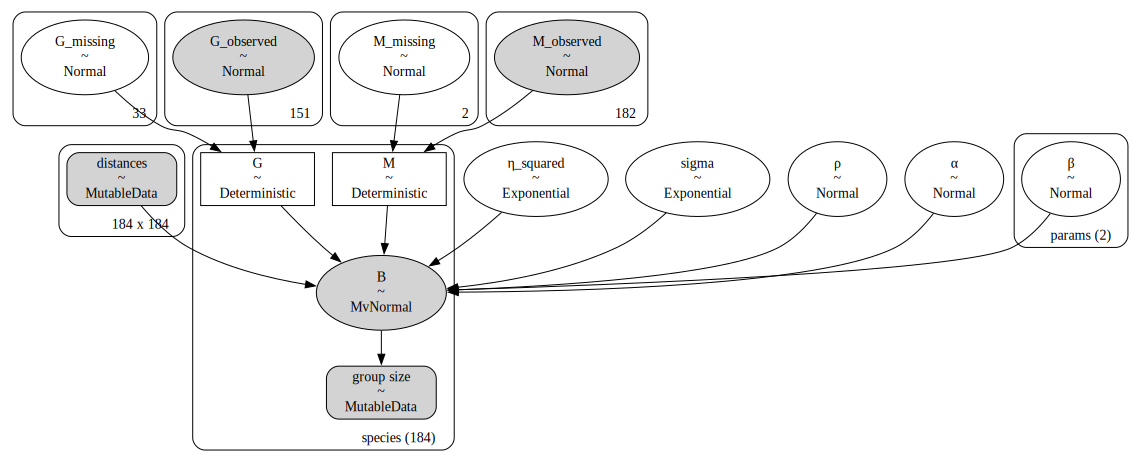

In [63]:
coords = {        
        'params': ['Group size', 'Body Mass']
    }

with pm.Model(coords= coords) as mc_model:
    data = {}
    RVs = {}
    register_data(RVs, data, missing_primates)
    add_distances(RVs, data, missing_phylogeny)
    gp_priors(RVs, data)

    ls = 1 / (2 * RVs['ρ'])    
    cov_func = RVs['η_squared'] * ExponentialHack(input_dim=data['distances'].shape.eval()[0], ls=ls) 

    G = pm.Normal("G", mu=0, sigma=1, observed = data['G'], dims='species')
    M = pm.Normal("M", mu=0, sigma=1, observed = data['M'], dims='species')

    mu = LinearMean(intercept=RVs['α'], coeffs=RVs['β'], X=pt.tensor.stack([G, M], axis=1))
    gp = pm.gp.Marginal(mean_func = mu, cov_func=cov_func)
    gp.marginal_likelihood("B", X=data['distances'], y=data['B'], sigma=RVs['sigma'], dims="species")

pm.model_to_graphviz(mc_model)

In [33]:
#with complete_cases_model as mc_model:
#    mc_model.set_data("brain size", masked_primates[:,1].reshape(-1), coords={'species': masked_primates[:, 0].reshape(-1)})
#    mc_model.set_data("body mass", masked_primates[:,2].reshape(-1), coords={'species': masked_primates[:, 0].reshape(-1)})
#    mc_model.set_data("group size", masked_primates[:,3].reshape(-1), coords={'species': masked_primates[:, 0].reshape(-1)})

#    mc_trace = sampling_jax.sample_blackjax_nuts()

In [64]:
with mc_model:
    mc_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:03.955598
Sampling...
Sampling time =  0:00:09.852140
Transforming variables...
Transformation time =  0:07:49.696876


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.146,0.175,-0.461,0.189,0.002,0.002,6131.0,2822.0,1.0
β[Group size],0.005,0.012,-0.017,0.027,0.000,0.000,6187.0,3363.0,1.0
β[Body Mass],0.750,0.031,0.691,0.808,0.000,0.000,5066.0,3035.0,1.0
ρ,2.955,0.251,2.493,3.431,0.003,0.002,6328.0,3002.0,1.0
M_missing[0],-1.773,0.139,-2.041,-1.521,0.002,0.001,6898.0,3209.0,1.0
M_missing[1],-0.716,0.110,-0.913,-0.502,0.001,0.001,6084.0,2868.0,1.0
η_squared,0.080,0.013,0.058,0.106,0.000,0.000,4156.0,3445.0,1.0
sigma,0.058,0.007,0.044,0.071,0.000,0.000,4742.0,2959.0,1.0


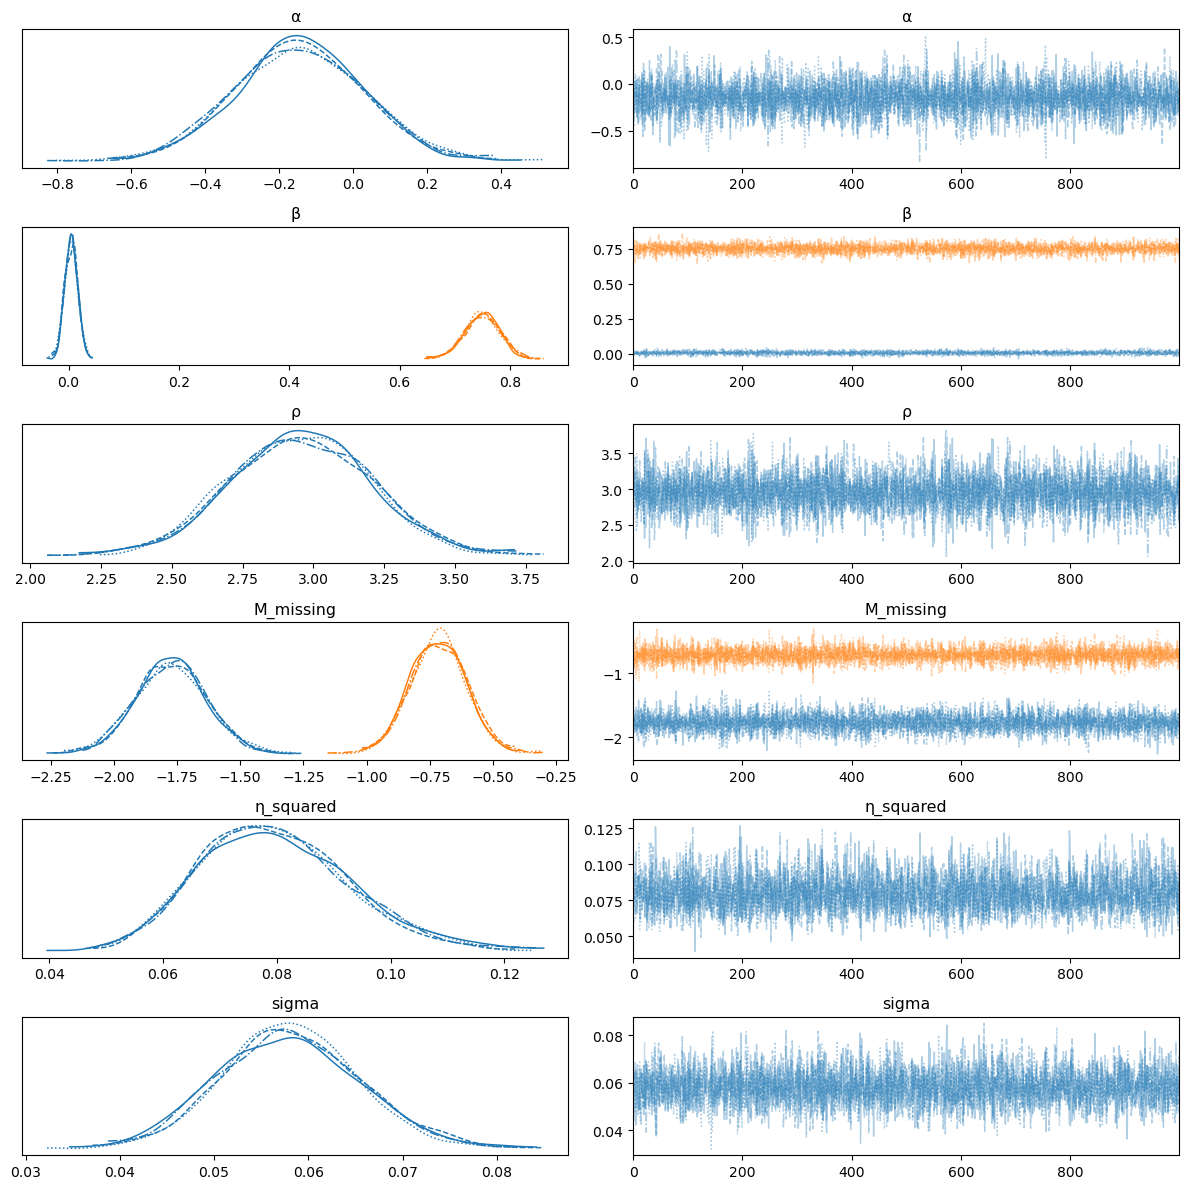

In [61]:
show_results(mc_trace, var_names=['~M', "~G"])

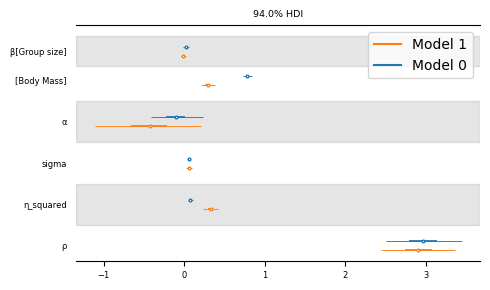

In [47]:
az.plot_forest([complete_cases_trace, mc_trace], figsize=(5,3), combined=True, textsize=6)
plt.tight_layout()
plt.show()